# ML quality issues prediction - SVM, Naive Bayes, XGBoost, LSTM on Reddit post data

In [1]:
import requests
import nltk
import pandas as pd
import re
import sys
from fake_useragent import UserAgent
import csv
import os
import time
import bs4 

C:\Users\xup641284\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df = pd.read_csv('reddit (label xps) all.csv')
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,question (technical)
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,question (purchasing)
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,question (technical)
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,question (technical)
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,question (technical)


In [3]:
# Creating a tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')

titles = ' '.join(df['content'])

# Tokenizing the text
tokens = tokenizer.tokenize(titles)

# Printing out the first 8 words / tokens 
print(tokens[:30])
titles[:400]

['hey', 'i', 'want', 'to', 'buy', 'a', '9315', 'with', 'linux', 'and', 'maybe', 'after', 'some', 'time', 'but', 'windows', 'on', 'it', 'do', 'i', 'have', 'to', 'give', 'up', 'on', 'any', 'features', 'which', 'the', 'oem']


'hey i want to buy a 9315 with linux, and maybe after some time but windows on it. do i have to give up on any features, which the oem xps ordered with windows has? currently i have a xps 15 9510 1080p model. for my use case which is light gaming and a heavy workflow with virtual machines and being used as a desktop replacement. i’m debating on if it’s worth buying a ultra? dells customer support h'

In [4]:
nltk.download('stopwords')

stopwordslist = ["helpxps", "dell", "xps", '13', '15', '17', '2','3', '0', '1', '8950', 'vs', '3050', '11', 'm1', 'i7','ram','ssd','support',
                 '9305', '9310', '9320', '9510', '9520', '9710', '9720', 'running', 'first', 'update', 'able', 'well', 'getting', 'plus', 'performance','discussionxps', 'helpdell', 'discussiondell',
                 'would', 'around', 'used','find', 'run', 'else', 'machine', 'see', 'gen', 'working','going', 'anything', 'model', 'also', 'know', 'work', 'anyone', 'one', 'tried', 'problem', 'need', 'could', 'use', 'intel','4k',
                 'get', 'something', 'better', 'help', 'using', 'really', 'like', 'thanks', 'time', 'buy', '3rd', 'laptop', 'back', 'even','two',
                 '4', '5', 'com','hi', 'good', 'however', 'seems', 'sure', 'go', 'lot', 'pro', '10', 'fine', 'bought', 
                 'right', 'much', 'looking', 'think', '32gb','life', 'want', 'every','https', 'since', 'issue', 'issues',
                 'another', 'got', 'new','still', 'will', 'apple', 'across', 'w', 'c', 'pd', 'news', 'known', 'xps13']

# Getting the English stop words from nltk
sw = nltk.corpus.stopwords.words('english')

sw.extend(stopwordslist)

# Printing out the first eight stop words
print(sw[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# A new list to hold Moby Dick with No Stop words
words_ns = []

# Appending to words_ns all words that are in words but not in sw
for word in tokens:
    if word not in sw:
        words_ns.append(word)

# Printing the first 5 words_ns to check that stop words are gone
print(words_ns[:30])

['hey', '9315', 'linux', 'maybe', 'windows', 'give', 'features', 'oem', 'ordered', 'windows', 'currently', '1080p', 'case', 'light', 'gaming', 'heavy', 'workflow', 'virtual', 'machines', 'desktop', 'replacement', 'debating', 'worth', 'buying', 'ultra', 'dells', 'customer', 'ok', 'already', 'thunderbolt']


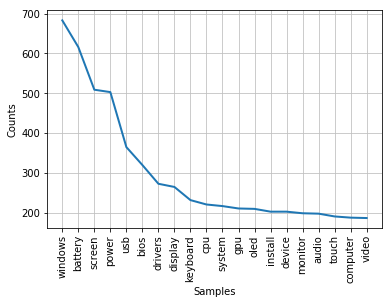

[('windows', 683), ('battery', 616), ('screen', 509), ('power', 503), ('usb', 365), ('bios', 320), ('drivers', 273), ('display', 265), ('keyboard', 232), ('cpu', 221), ('system', 217), ('gpu', 211), ('oled', 210), ('install', 203), ('device', 203), ('monitor', 199), ('audio', 198), ('touch', 191), ('computer', 188), ('video', 187)]


In [6]:
# This command display figures inline
%matplotlib inline

# Creating the word frequency distribution
freqdist = nltk.FreqDist(words_ns)

# Plotting the word frequency distribution
freqdist.plot(20)
print(freqdist.most_common(20))

# XPS wordcloud

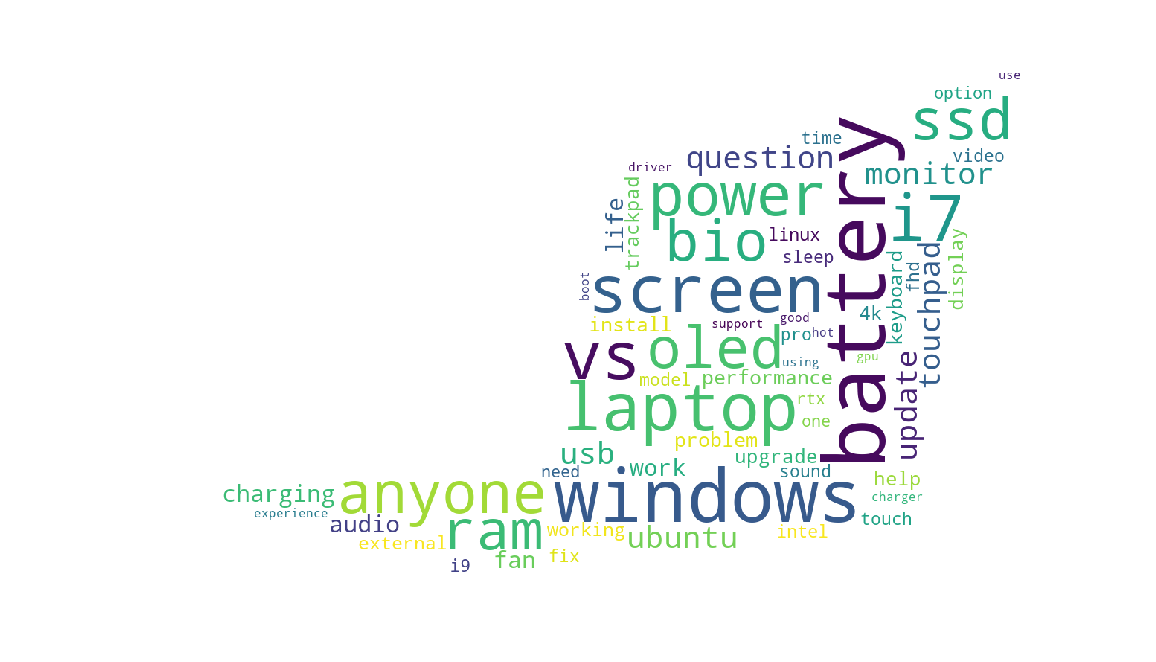

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

mask = np.array(Image.open('xps.jpg'))

stopwordslist = ['8950', '9300','9520','9720', '9315', '9310', '9320','9710', '9510', '9305', '11', '2022', '17', '13', '15', 'helpxps', 'helpxps13', 'dell', 'xps', 'anybody', 'discussionis', 'discussionxps', 'helpdell', 'discussiondell', 'buy', '3rd', 'issue', 'issues', 'does', 'another', 'got', 'new', 'still', 'will', 'apple', 'across','plus', 'w', 'c', 'pd', 'news', 'known', 'xps13']
stopwords = stopwordslist + list(STOPWORDS)

# Join the different processed titles together.
long_string = '-'.join(df['title'])

# Create a WordCloud object
wordcloud = WordCloud(mask = mask, stopwords = stopwords, collocations=False, max_words=60, background_color="white")

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

plt.figure(figsize=[20,20])
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('xps reddit (wordcloud).jpg')
plt.show()

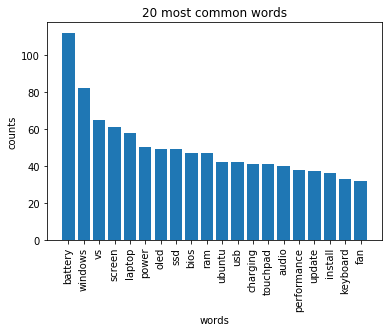

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = zip(words, total_counts)
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts, align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words

from sklearn.feature_extraction import text 

stopwordslist = ['8950', '9300','9520','9720', '9315', '9310', '9320','9710', '9510', '9305', '11', '3050', '2022', '17', '13', '15', 'helpxps', 'helpxps13', 'dell', 'xps', 'i7', 'help', 'i9', 'life', 'just', 'question', 'work', 'anybody', 'discussionis', 'discussionxps', 'helpdell', 'discussiondell', 'buy', '3rd', 'issue', 'issues', 'does', 'another', 'got', 'new', 'still', 'will', 'apple', 'across','plus', 'w', 'c', 'pd', 'news', 'known', 'xps13']
stop_words = text.ENGLISH_STOP_WORDS.union(stopwordslist)

count_vectorizer = CountVectorizer(stop_words=stop_words)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['title'])

# Visualise the 10 most common words
plot_20_most_common_words(count_data, count_vectorizer)

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 3

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
charging audio power

Topic #2:
fan noise trackpad

Topic #3:
vs windows install

Topic #4:
battery ssd screen

Topic #5:
usb ubuntu 22

Topic #6:
ram upgrade battery

Topic #7:
monitor external gaming

Topic #8:
touchpad keyboard hot

Topic #9:
bios update rtx

Topic #10:
sleep review fix


# NLP

In [10]:
# Set seed for reproducibility
import random; random.seed(53)

# Import all we need from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics

In [11]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (label xps) all.csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

# Create target
y = df['label']
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label,combined
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,question (technical),xps13 9315 without windows hey i want to buy a...
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,question (purchasing),galaxy book 3 ultra or xps 15 oled currently i...
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,question (technical),how do i disable the proximity sensor on xps 9...
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,question (technical),ir sensor i've recently got my hands on a xps ...
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,question (technical),dell xps 15 9520 performance issue after ram u...


In [12]:
nltk.download('stopwords')

stopwordslist = ["helpxps", "dell", "xps", '13', '15', '17', '2','3', '0', '1', '8950', 'vs', '3050', '11', 'm1', 'i7','ram','ssd','support',
                 '9305', '9310', '9320', '9510', '9520', '9710', '9720', 'running', 'first', 'update', 'able', 'well', 'getting', 'plus', 'performance','discussionxps', 'helpdell', 'discussiondell',
                 'would', 'around', 'used','find', 'run', 'else', 'machine', 'see', 'gen', 'working','going', 'anything', 'model', 'also', 'know', 'work', 'anyone', 'one', 'tried', 'problem', 'need', 'could', 'use', 'intel','4k',
                 'get', 'something', 'better', 'help', 'using', 'really', 'like', 'thanks', 'time', 'buy', '3rd', 'laptop', 'back', 'even','two',
                 '4', '5', 'com','hi', 'good', 'however', 'seems', 'sure', 'go', 'lot', 'pro', '10', 'fine', 'bought', 
                 'right', 'much', 'looking', 'think', '32gb','life', 'want', 'every','https', 'since', 'issue', 'issues',
                 'another', 'got', 'new','still', 'will', 'apple', 'across', 'w', 'c', 'pd', 'news', 'known', 'xps13']

# Getting the English stop words from nltk
sw = nltk.corpus.stopwords.words('english')

sw.extend(stopwordslist)

# Printing out the first eight stop words
print(sw[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# lemmatization
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_data = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['combined'].iloc[i])
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in sw]
    review = ' '.join(review)
    df_data.append(review)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Split training and testing data, choose between the combined only or lemmatization
X_train, X_test, y_train, y_test = train_test_split(df_data, y, random_state=0, test_size=0.2, stratify = y)

In [15]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Naive Bayes

In [16]:
# TF-IDF Gridsearch
params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, verbose=5)
multinomial_nb_grid.fit(tfidf_train,y_train)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(tfidf_train,y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(tfidf_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................................alpha=0.001; total time=   0.0s
[CV 2/5] END ....................................alpha=0.001; total time=   0.0s
[CV 3/5] END ....................................alpha=0.001; total time=   0.0s
[CV 4/5] END ....................................alpha=0.001; total time=   0.0s
[CV 5/5] END ....................................alpha=0.001; total time=   0.0s
[CV 1/5] END .....................................alpha=0.01; total time=   0.0s
[CV 2/5] END .....................................alpha=0.01; total time=   0.0s
[CV 3/5] END .....................................alpha=0.01; total time=   0.0s
[CV 4/5] END .....................................alpha=0.01; total time=   0.0s
[CV 5/5] END .....................................alpha=0.01; total time=   0.0s
[CV 1/5] END ......................................alpha=0.1; total time=   0.0s
[CV 2/5] END ....................................

In [17]:
# count Gridsearch
params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, verbose=5)
multinomial_nb_grid.fit(count_train,y_train)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(count_train,y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(count_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................................alpha=0.001; total time=   0.0s
[CV 2/5] END ....................................alpha=0.001; total time=   0.0s
[CV 3/5] END ....................................alpha=0.001; total time=   0.0s
[CV 4/5] END ....................................alpha=0.001; total time=   0.0s
[CV 5/5] END ....................................alpha=0.001; total time=   0.0s
[CV 1/5] END .....................................alpha=0.01; total time=   0.0s
[CV 2/5] END .....................................alpha=0.01; total time=   0.0s
[CV 3/5] END .....................................alpha=0.01; total time=   0.0s
[CV 4/5] END .....................................alpha=0.01; total time=   0.0s
[CV 5/5] END .....................................alpha=0.01; total time=   0.0s
[CV 1/5] END ......................................alpha=0.1; total time=   0.0s
[CV 2/5] END ....................................

In [18]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB(alpha = 0.1)
tfidf_nb.fit(tfidf_train, y_train)

# Run predict on your TF-IDF test data to get your predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_nb_score = metrics.accuracy_score(tfidf_nb_pred, y_test)

# Create a MulitnomialNB model
count_nb = MultinomialNB(alpha=0.01)
count_nb.fit(count_train, y_train)

# Run predict on your count test data to get your predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of your predictions
count_nb_score = metrics.accuracy_score(count_nb_pred, y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.8292011019283747
NaiveBayes Count Score:  0.8236914600550964


## TF-IDF

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_nb_pred))

                       precision    recall  f1-score   support

              dislike       1.00      0.25      0.40        12
                 like       0.00      0.00      0.00         3
question (operations)       1.00      0.17      0.29        12
question (purchasing)       0.70      0.42      0.52        55
 question (technical)       0.84      0.97      0.90       281

             accuracy                           0.83       363
            macro avg       0.71      0.36      0.42       363
         weighted avg       0.82      0.83      0.80       363



C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  3   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   2   0   0]
 [  0   0   2  23   8]
 [  9   3   8  32 273]]


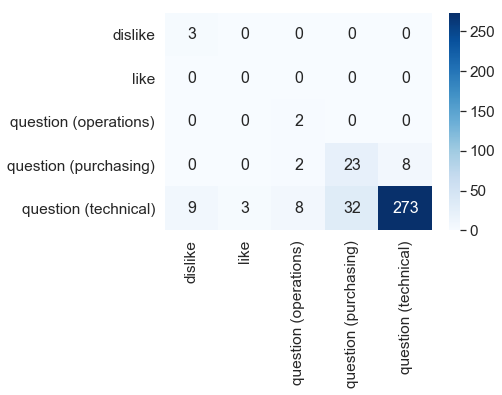

In [20]:
cm=metrics.confusion_matrix(tfidf_nb_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

## CountVectorizer

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, count_nb_pred))

                       precision    recall  f1-score   support

              dislike       1.00      0.33      0.50        12
                 like       0.00      0.00      0.00         3
question (operations)       1.00      0.50      0.67        12
question (purchasing)       0.56      0.58      0.57        55
 question (technical)       0.87      0.91      0.89       281

             accuracy                           0.82       363
            macro avg       0.69      0.47      0.53       363
         weighted avg       0.83      0.82      0.82       363



[[  4   0   0   0   0]
 [  0   0   0   0   1]
 [  0   0   6   0   0]
 [  0   0   2  32  23]
 [  8   3   4  23 257]]


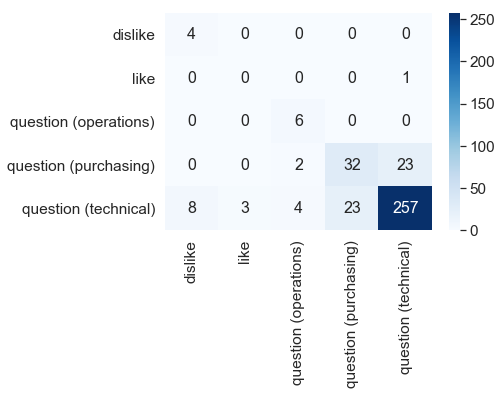

In [22]:
cm=metrics.confusion_matrix(count_nb_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

# Linear SVM

In [23]:
# TF-IDF Gridsearch
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
         }

linearsvc_grid = GridSearchCV(LinearSVC(), param_grid=params, cv=5, verbose=5)
linearsvc_grid.fit(tfidf_train,y_train)

print('Train Accuracy : %.3f'%linearsvc_grid.best_estimator_.score(tfidf_train,y_train))
print('Test Accuracy : %.3f'%linearsvc_grid.best_estimator_.score(tfidf_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%linearsvc_grid.best_score_)
print('Best Parameters : ',linearsvc_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ........................................C=0.001; total time=   0.0s
[CV 2/5] END ........................................C=0.001; total time=   0.0s
[CV 3/5] END ........................................C=0.001; total time=   0.0s
[CV 4/5] END ........................................C=0.001; total time=   0.0s
[CV 5/5] END ........................................C=0.001; total time=   0.0s
[CV 1/5] END .........................................C=0.01; total time=   0.0s
[CV 2/5] END .........................................C=0.01; total time=   0.0s
[CV 3/5] END .........................................C=0.01; total time=   0.0s
[CV 4/5] END .........................................C=0.01; total time=   0.0s
[CV 5/5] END .........................................C=0.01; total time=   0.0s
[CV 1/5] END ..........................................C=0.1; total time=   0.0s
[CV 2/5] END ....................................

C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/5] END ..........................................C=100; total time=   0.4s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/5] END ..........................................C=100; total time=   0.3s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 3/5] END ..........................................C=100; total time=   0.4s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 4/5] END ..........................................C=100; total time=   0.2s
[CV 5/5] END ..........................................C=100; total time=   0.2s
Train Accuracy : 0.995
Test Accuracy : 0.837
Best Accuracy Through Grid Search : 0.836
Best Parameters :  {'C': 1}


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
# count Gridsearch
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
         }

linearsvc_grid = GridSearchCV(LinearSVC(), param_grid=params, cv=5, verbose=5)
linearsvc_grid.fit(count_train,y_train)

print('Train Accuracy : %.3f'%linearsvc_grid.best_estimator_.score(count_train,y_train))
print('Test Accuracy : %.3f'%linearsvc_grid.best_estimator_.score(count_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%linearsvc_grid.best_score_)
print('Best Parameters : ',linearsvc_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ........................................C=0.001; total time=   0.0s
[CV 2/5] END ........................................C=0.001; total time=   0.0s
[CV 3/5] END ........................................C=0.001; total time=   0.0s
[CV 4/5] END ........................................C=0.001; total time=   0.0s
[CV 5/5] END ........................................C=0.001; total time=   0.0s
[CV 1/5] END .........................................C=0.01; total time=   0.0s
[CV 2/5] END .........................................C=0.01; total time=   0.0s
[CV 3/5] END .........................................C=0.01; total time=   0.0s
[CV 4/5] END .........................................C=0.01; total time=   0.0s
[CV 5/5] END .........................................C=0.01; total time=   0.0s
[CV 1/5] END ..........................................C=0.1; total time=   0.0s
[CV 2/5] END ....................................

C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/5] END ............................................C=1; total time=   0.1s
[CV 3/5] END ............................................C=1; total time=   0.1s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 4/5] END ............................................C=1; total time=   0.1s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 5/5] END ............................................C=1; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/5] END ...........................................C=10; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/5] END ...........................................C=10; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 3/5] END ...........................................C=10; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 4/5] END ...........................................C=10; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 5/5] END ...........................................C=10; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/5] END ..........................................C=100; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/5] END ..........................................C=100; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 3/5] END ..........................................C=100; total time=   0.2s


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 4/5] END ..........................................C=100; total time=   0.1s
[CV 5/5] END ..........................................C=100; total time=   0.2s
Train Accuracy : 0.994
Test Accuracy : 0.835
Best Accuracy Through Grid Search : 0.825
Best Parameters :  {'C': 0.1}


C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
# Create a LinearSVM model
tfidf_svc = LinearSVC(C=1)
tfidf_svc.fit(tfidf_train, y_train)

# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate your accuracy using the metrics module
tfidf_svc_score = metrics.accuracy_score(tfidf_svc_pred, y_test)


print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

LinearSVC Score:   0.837


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_svc_pred))

                       precision    recall  f1-score   support

              dislike       1.00      0.25      0.40        12
                 like       0.00      0.00      0.00         3
question (operations)       1.00      0.42      0.59        12
question (purchasing)       0.68      0.47      0.56        55
 question (technical)       0.85      0.96      0.90       281

             accuracy                           0.84       363
            macro avg       0.71      0.42      0.49       363
         weighted avg       0.83      0.84      0.82       363



C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xup641284\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  3   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   5   0   0]
 [  1   0   0  26  11]
 [  8   3   7  29 270]]


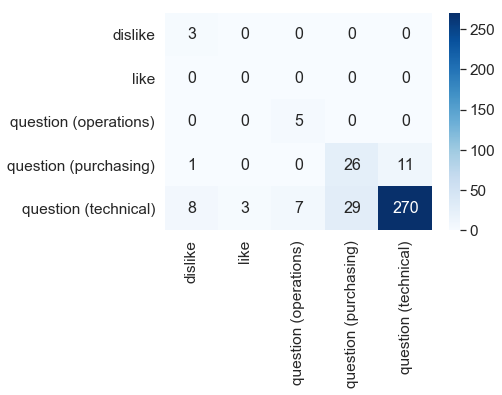

In [27]:
cm=metrics.confusion_matrix(tfidf_svc_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [28]:
# Create a LinearSVM model
count_svc = LinearSVC(C=0.1)
count_svc.fit(count_train, y_train)

# Run predict on your tfidf test data to get your predictions
count_svc_pred = count_svc.predict(count_test)

# Calculate your accuracy using the metrics module
count_svc_score = metrics.accuracy_score(count_svc_pred, y_test)


print("LinearSVC Score:   %0.3f" % count_svc_score)

LinearSVC Score:   0.835


[[  4   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   6   1   0]
 [  1   0   2  27  15]
 [  7   3   4  27 266]]


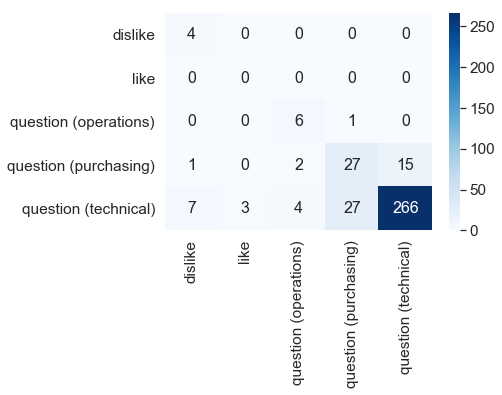

In [29]:
cm=metrics.confusion_matrix(count_svc_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

# XGBoost

In [30]:
df = pd.read_csv('reddit (label xps) all.csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

# Create target
y = df['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y, random_state=0, test_size=0.2, stratify = y)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [32]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [33]:
# tfidf Gridsearch
params = {
        'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1, 5],
        'reg_lambda': [0, 0.5, 1, 5]
        }

xgboost_grid = GridSearchCV(XGBClassifier(), param_grid=params, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
xgboost_grid.fit(tfidf_train,y_train)

print('Train Accuracy : %.3f'%xgboost_grid.best_estimator_.score(tfidf_train,y_train))
print('Test Accuracy : %.3f'%xgboost_grid.best_estimator_.score(tfidf_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%xgboost_grid.best_score_)
print('Best Parameters : ',xgboost_grid.best_params_)

Train Accuracy : 0.970
Test Accuracy : 0.815
Best Accuracy Through Grid Search : 0.816
Best Parameters :  {'colsample_bytree': 0.8, 'reg_alpha': 1, 'reg_lambda': 5}


In [34]:
# count Gridsearch
params = {
        'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1, 5],
        'reg_lambda': [0, 0.5, 1, 5]
        }

xgboost_grid = GridSearchCV(XGBClassifier(), param_grid=params, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
xgboost_grid.fit(count_train,y_train)

print('Train Accuracy : %.3f'%xgboost_grid.best_estimator_.score(count_train,y_train))
print('Test Accuracy : %.3f'%xgboost_grid.best_estimator_.score(count_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%xgboost_grid.best_score_)
print('Best Parameters : ',xgboost_grid.best_params_)

Train Accuracy : 0.968
Test Accuracy : 0.835
Best Accuracy Through Grid Search : 0.827
Best Parameters :  {'colsample_bytree': 0.8, 'reg_alpha': 1, 'reg_lambda': 1}


In [35]:
from xgboost import XGBClassifier

# Create a MulitnomialNB model
tfidf_xgt = XGBClassifier(colsample_bytree = 0.3, reg_alpha = 0, reg_lambda = 1, subsample = 1, min_child_weight = 1)
tfidf_xgt.fit(tfidf_train, y_train)

# Run predict on your TF-IDF test data to get your predictions
tfidf_xgt_pred = tfidf_xgt.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_xgt_score = metrics.accuracy_score(tfidf_xgt_pred, y_test)

# Create a MulitnomialNB model
count_xgt = XGBClassifier(colsample_bytree = 0.3, reg_alpha = 0, reg_lambda = 0, subsample=1.0, min_child_weight = 1)
count_xgt.fit(count_train, y_train)

# Run predict on your count test data to get your predictions
count_xgt_pred = count_xgt.predict(count_test)

# Calculate the accuracy of your predictions
count_xgt_score = metrics.accuracy_score(count_xgt_pred, y_test)

print('XGboost Tfidf Score: ', tfidf_xgt_score)
print('XGboost Count Score: ', count_xgt_score)

XGboost Tfidf Score:  0.8236914600550964
XGboost Count Score:  0.8264462809917356


# LSTM

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import time
from collections import Counter

In [121]:
# Load data
df = pd.read_csv('reddit (label xps) all.csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

# Create target
y_label = df['label']

In [122]:
y = pd.get_dummies(y_label).values
name = pd.get_dummies(y_label)
#get column names that were not in the original dataframe
new_cols = name.columns[~name.columns.isin(df.columns)]
print('Shape of label tensor:', y.shape)
print(new_cols)

Shape of label tensor: (1811, 5)
Index(['dislike', 'like', 'question (operations)', 'question (purchasing)',
       'question (technical)'],
      dtype='object')


In [123]:
nltk.download('stopwords')

stopwordslist = ["helpxps", "dell", "xps", '13', '15', '17', '2','3', '0', '1', '8950', '8950,', '..', 'x.', 'vs', '(9320)', '9320?', '-', ':', '3050', '11', 'm1', 'i7','ram','ssd','support',
                 '9305', '9310', '9320', '9510', '9520', '9710', '9720', '9720.', '9315', '9315 ', 'plus', '3060', 'running', 'high', 'review','sometimes', 'update', 'able', 'well', 'getting', 'plus', 'performance','discussionxps', 'helpdell', 'discussiondell',
                 'would', 'dont', 'find', 'run', 'else', 'machine', 'see', 'gen', 'working', 'cant', 'going', 'anything', 'model', 'also', 'know', 'work', 'anyone', 'one', 'tried', 'problem', 'need', 'could', 'use', 'intel','4k',
                 'get', 'something', 'better', 'help', 'using', 'really', 'like', 'thanks', 'time', 'buy', '3rd', 'laptop', 'back', 'even','two',
                 '4', '5', 'com','hi', 'good', 'however', 'seems', 'sure', 'go', 'lot', 'pro', '10', 'fine', 'bought', 
                 'right', 'much', 'looking', 'think', '32gb','life', 'want', 'every','https', 'since', 'issue', 'issues',
                 'another', 'got', 'new','still', 'will', 'apple', 'across', 'w', 'c', 'pd', 'news', 'known', 'xps13']

# Getting the English stop words from nltk
sw = nltk.corpus.stopwords.words('english')

sw.extend(stopwordslist)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
from collections import Counter
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            word = re.sub('[^a-zA-Z]', ' ',word)
            word = word.strip().replace(' ', '')
            if word not in sw:
                count[word.strip().replace(' ', '')] += 1
    return count

text_values = df['combined']

counter = counter_word(text_values)
list(counter.items())[:10]

[('', 10448),
 ('without', 137),
 ('windows', 750),
 ('hey', 81),
 ('linux', 131),
 ('maybe', 139),
 ('give', 58),
 ('features', 13),
 ('oem', 25),
 ('ordered', 93)]

In [125]:
# lemmatization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_data = []
for i in range(0, len(text_values)):
    review = re.sub('[^a-zA-Z]', ' ', text_values.iloc[i])
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in sw]
    review = ' '.join(review)
    df_data.append(review)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [126]:
# sparse matrix
#df = pd.DataFrame([counter.keys(), counter.values()], index = ['word','count']).T
#df = df.pivot(columns = 'word', values = 'count').fillna(0)
#df

In [127]:
# The maximum number of words to be used. (most frequent)
vocab_size = len(counter)

# This is fixed
embedding_dim = 32

# Max number of words in each complaint
max_length = 20

tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}z~', lower=True)
tokenizer.fit_on_texts(df['combined'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 10622 unique tokens.


In [128]:
X = tokenizer.texts_to_sequences(df_data)
X = pad_sequences(X, maxlen=max_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1811, 20)


In [129]:
y = pd.get_dummies(y_label).values
print('Shape of label tensor:', y.shape)
np.unique(y_label)

Shape of label tensor: (1811, 5)


array(['dislike', 'like', 'question (operations)',
       'question (purchasing)', 'question (technical)'], dtype=object)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1448, 20) (1448, 5)
(363, 20) (363, 5)


In [131]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences = True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='softmax'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            289632    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 20, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                      

In [132]:
epochs = 40
batch_size = 64

history = model.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/40
19/19 [==============================] - 6s 72ms/step - loss: 1.5857 - accuracy: 0.4085 - val_loss: 1.5326 - val_accuracy: 0.7690
Epoch 2/40
19/19 [==============================] - 1s 35ms/step - loss: 1.4551 - accuracy: 0.7824 - val_loss: 1.3900 - val_accuracy: 0.7690
Epoch 3/40
19/19 [==============================] - 1s 36ms/step - loss: 1.3394 - accuracy: 0.7824 - val_loss: 1.2998 - val_accuracy: 0.7690
Epoch 4/40
19/19 [==============================] - 1s 31ms/step - loss: 1.2628 - accuracy: 0.7824 - val_loss: 1.2387 - val_accuracy: 0.7690
Epoch 5/40
19/19 [==============================] - 1s 32ms/step - loss: 1.2065 - accuracy: 0.7824 - val_loss: 1.1919 - val_accuracy: 0.7690
Epoch 6/40
19/19 [==============================] - 1s 30ms/step - loss: 1.1616 - accuracy: 0.7824 - val_loss: 1.1534 - val_accuracy: 0.7690
Epoch 7/40
19/19 [==============================] - 1s 35ms/step - loss: 1.1240 - accuracy: 0.7824 - val_loss: 1.1194 - val_accuracy: 0.7690
Epoch 8/40
19

In [133]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.78 - 0s 5ms/step - loss: 0.7677 - accuracy: 0.7796
Test set
  Loss: 0.768
  Accuracy: 0.780


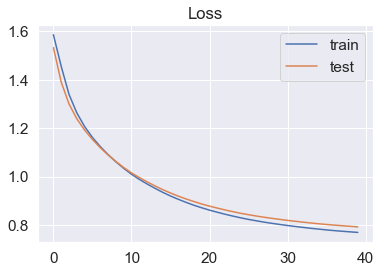

In [134]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

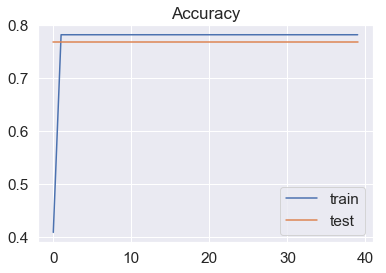

In [135]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [136]:
model_loss = pd.DataFrame(history.history)
model_loss.head(10)

,loss,accuracy,val_loss,val_accuracy
0,1.585717,0.408463,1.532621,0.768966
1,1.455064,0.782383,1.390001,0.768966
2,1.339385,0.782383,1.299761,0.768966
3,1.262818,0.782383,1.238737,0.768966
4,1.206479,0.782383,1.191891,0.768966
5,1.161593,0.782383,1.153380,0.768966
6,1.124042,0.782383,1.119357,0.768966
7,1.090936,0.782383,1.089403,0.768966
8,1.061100,0.782383,1.062341,0.768966
9,1.034256,0.782383,1.037595,0.768966


In [137]:
df['combined'][0]

'xps13 9315 without windows hey i want to buy a 9315 with linux, and maybe after some time but windows on it. do i have to give up on any features, which the oem xps ordered with windows has?'

In [138]:
new_complaint = [df['combined'][0]]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = list(new_cols)
print(pred, labels[np.argmax(pred)])

[[0.04420457 0.04207869 0.06442615 0.13514401 0.71414655]] question (technical)


# Keywords

In [139]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (label xps) all.csv')

df = df.dropna(axis=0)

# combined only list
df['context'] = df['title'] + ' ' + df['content']

df = df.drop(['source', 'number of likes', 'number of comments', 'title', 'content', 'link'], axis =1)

df.head()

,counter,post date,model,label,context
0,1,2023-02-15,xps 13 9315,question (technical),xps13 9315 without windows hey i want to buy a...
1,2,2023-02-09,xps 15 9510,question (purchasing),galaxy book 3 ultra or xps 15 oled currently i...
2,3,2023-02-08,xps 15 9520,question (technical),how do i disable the proximity sensor on xps 9...
3,4,2023-02-07,xps 13 9310,question (technical),ir sensor i've recently got my hands on a xps ...
4,5,2023-02-02,xps 15 9520,question (technical),dell xps 15 9520 performance issue after ram u...


In [140]:
# lemmatization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# remove stop words
df_nosw = []
for i in range(0, len(df['context'])):
    review = re.sub('[^a-zA-Z0-9]', ' ', df['context'].iloc[i])
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    df_nosw.append(review)

df['context'] = df_nosw
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,counter,post date,model,label,context
0,1,2023-02-15,xps 13 9315,question (technical),xps13 9315 without window hey i want to buy a ...
1,2,2023-02-09,xps 15 9510,question (purchasing),galaxy book 3 ultra or xps 15 oled currently i...
2,3,2023-02-08,xps 15 9520,question (technical),how do i disable the proximity sensor on xps 9...
3,4,2023-02-07,xps 13 9310,question (technical),ir sensor i ve recently got my hand on a xps 1...
4,5,2023-02-02,xps 15 9520,question (technical),dell xps 15 9520 performance issue after ram u...


In [141]:
keywords = ['keyboard', 'trackpad', 'audio', 'speaker', 'camera', 'webcam', 'crash', 'track pad', 'freeze', 'display', 'lcd', 
            'graphic', 'vmware', 'disappointing', 'oled', 'unresponsive', 'hinge', 'touchpad', 'thunderbolt', 'port', 'bad', 'configuration', 'backlit', 'ram', 'fps',  'video', 'cover',
            'discontinued', 'recalled', 'selling', 'usb', 'driver', 'drives', 'linux', 'boot', 'hot', 'battery', 'stuttering', 'purchasing',
            'stuck', 'frustrating', 'logo', 'mother board', 'motherboard', 'fail', 'sunk', 'sink', 'corner', 'bios', 'firmware', 'kb',
            'review' , 'ssd', 'install', 'resolution', 'wifi', 'slow', 'terrible', 'ubuntu', 'monitor', 'adapter', 
            'shipped', 'shipment', 'ship', 'error', 'sunk', 'sink', 'corner', 'bios', 'firmware', 'refurbished', 'repair', 'repaired', 
            'charger', 'fan', 'charging', 'charge', 'air', 'cooling', 'disappointed', 'rattle', 'rattling', 'noise', 'buy', 
            'heat', 'power', 'released','release', 'volume', 'drain', 'missing', 'recall', 'remove', 'doubt', 'gpu', 'dock', 'wobble', 'break', 'touch pen', 
            'trouble', 'switch', 'overheat', 'cost', 'play', 'pleasant', 'support', 'search', 'disk', 'consider', 'cursor', 'fingerprint', 'overheating', 'throttling', 'throttle', 'thermal', 'warranty', 'flicker', 'against', 'tearing', 'haptic', 'suck', 'hibernate', 'undervolting', 'delay', 'awful', 'hardcase', 'touch', 'disaster', 'driver', 'popping', 'button', 'chassis', 'cracking', 
            'lid', 'atrocious', 'gorgeous', 'impressed', 'service','decal', 'recommendation', 'fps', 'case', 'pixel', 'purchase', 'option', 'happy', 'satisfied', 'dislike', 'safeguard', 'garbage', 'window', 'shutting', 'underwhelmed', 'got', 'skin', 'looking', 'decide', 'recommend', 'difference', 'choosing', 'replace', 'glitch', 'shutdown', 'saturation', 'stain', 'run', 'order', 'molding', 'temp', 'color', 'oversaturated', 'love', 'store', 'complain','return', 'stuttering', 'microphone', 'desperation', 'headphone', 'buzzing', 'ridiculous', 'worse', 'screen', 'poor', 'low',
            'replacement', 'backlight', 'slot', 'compatibility', 'key', 'feedback', 'lagging', 'compare', 'egpu', 'horrible', 'cpu', 'bluetooth', 'dgpu', 'lag', 'retrospective','photo', 'stereo', 'dongle', 'sound']

In [142]:
df['keyword'] = df['context'].str.findall('|'.join(keywords)).apply(set).str.join(', ')
df.insert(4, 'keyword', df.pop('keyword'))
df.head()

,counter,post date,model,label,keyword,context
0,1,2023-02-15,xps 13 9315,question (technical),"linux, window, buy, order",xps13 9315 without window hey i want to buy a ...
1,2,2023-02-09,xps 15 9510,question (purchasing),"replace, oled, buy, speaker, love, charger, su...",galaxy book 3 ultra or xps 15 oled currently i...
2,3,2023-02-08,xps 15 9520,question (technical),"window, screen",how do i disable the proximity sensor on xps 9...
3,4,2023-02-07,xps 13 9310,question (technical),"error, camera, linux, got, driver, return, ins...",ir sensor i ve recently got my hand on a xps 1...
4,5,2023-02-02,xps 15 9520,question (technical),"slow, run, lag, skin, ram, install, configuration",dell xps 15 9520 performance issue after ram u...


In [143]:
df['context'][0]

'xps13 9315 without window hey i want to buy a 9315 with linux and maybe after some time but window on it do i have to give up on any feature which the oem xps ordered with window ha'

In [144]:
df['keyword'][0]

'linux, window, buy, order'

# All prediction

In [145]:
import pandas as pd

# Load data
df = pd.concat(map(pd.read_csv, ['reddit (label inspiron).csv', 'reddit (label vostro).csv','reddit (label dellg15).csv','reddit (label xps) all.csv']))

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

y = df['label']

df.head()

,counter,post date,model,source,label,number of likes,number of comments,title,content,link,combined
0,1,2022-08-04,inspiron 14 5420,inspiron (dell) - reddit,question (technical),1,0,inspiron 14 vs xps 13 for use with external,my partner has a desktop with three monitors. ...,https://www.reddit.com/r/Dell/comments/wfxclf/...,inspiron 14 vs xps 13 for use with external my...
1,2,2022-07-31,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),3,6,inspiron 16 plus 7620 battery draining like a,"hey all, had my new inspiron 16 plus 7620 a we...",https://www.reddit.com/r/Dell/comments/wcf3xp/...,inspiron 16 plus 7620 battery draining like a ...
2,3,2022-07-30,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),3,2,dell inspiron 16 plus 7620 bad audio problem with,"hello, i recently bought a brand new dell insp...",https://www.reddit.com/r/Dell/comments/wbsdnz/...,dell inspiron 16 plus 7620 bad audio problem w...
3,4,2022-07-26,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),1,6,bought an inspiron 7620; need ram,i just bought an inspiron 7620 an am so far ex...,https://www.reddit.com/r/Dell/comments/w88xlc/...,bought an inspiron 7620; need ram i just bough...
4,5,2022-07-23,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),0,4,inspiron 16 plus 7620 - overheating in sleep,"hi, just received my new laptop. nice design a...",https://www.reddit.com/r/Dell/comments/w5qk65/...,inspiron 16 plus 7620 - overheating in sleep h...


In [146]:
nltk.download('stopwords')

stopwordslist = ["helpxps", "dell", "xps", '13', '15', '17', '2','3', '0', '1', '8950', 'vs', '3050', '11', 'm1', 'i7', 'ram','ssd','support',
                 '9305', '9310', '9320', '9510', '9520', '9710', '9720', 'running','first', 'inspiron', 'update', 'able', 'well', 'getting', 'plus', 'performance','discussionxps', 'helpdell', 'discussiondell',
                 'would', 'around', 'used','find', 'run', 'else', 'machine', 'see', 'gen', 'working','going', 'anything', 'model', 'also', 'know', 'work', 'anyone', 'one', 'tried', 'problem', 'need', 'could', 'use', 'intel','4k',
                 'get', 'something', 'better', 'help', 'using', 'really', 'like', 'thanks', 'time', 'buy', '3rd', 'laptop', 'back', 'even','two',
                 '4', '5', 'com','hi', 'good', 'however', 'seems', 'sure', 'go', 'lot', 'pro', '10', 'fine', 'bought', 
                 'right', 'much', 'looking', 'think', '32gb','life', 'want', 'every','https', 'since', 'issue', 'issues',
                 'another', 'got', 'new','still', 'will', 'apple', 'across', 'w', 'c', 'pd', 'news', 'known', 'xps13']

# Getting the English stop words from nltk
sw = nltk.corpus.stopwords.words('english')

sw.extend(stopwordslist)

# Printing out the first eight stop words
print(sw[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
# lemmatization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_data = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['combined'].iloc[i])
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in sw]
    review = ' '.join(review)
    df_data.append(review)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xup641284\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [148]:
# Split training and testing data, choose between the combined only or lemmatization
X_train, X_test, y_train, y_test = train_test_split(df_data, y, random_state=0, test_size=0.2, stratify = y)

In [149]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=sw, max_df=0.3, min_df=0.001)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [150]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB(alpha = 0.1)
tfidf_nb.fit(tfidf_train, y_train)

# Run predict on your TF-IDF test data to get your predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_nb_score = metrics.accuracy_score(tfidf_nb_pred, y_test)

# Create a MulitnomialNB model
count_nb = MultinomialNB(alpha=0.01)
count_nb.fit(count_train, y_train)

# Run predict on your count test data to get your predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of your predictions
count_nb_score = metrics.accuracy_score(count_nb_pred, y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.8216216216216217
NaiveBayes Count Score:  0.8216216216216217


[[  2   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   2   0   1]
 [  0   0   2  17   4]
 [ 10   3   7  39 283]]


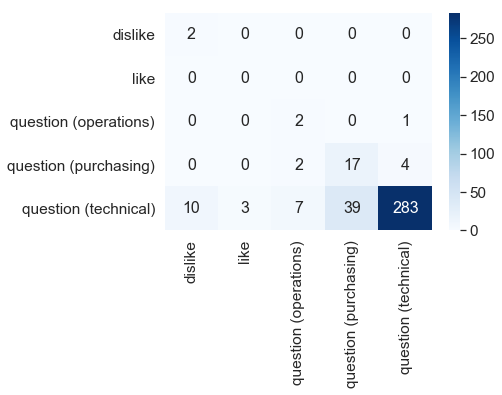

In [151]:
cm=metrics.confusion_matrix(tfidf_nb_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

[[  4   0   0   1   3]
 [  0   0   0   0   1]
 [  0   0   5   1   0]
 [  0   0   2  28  17]
 [  8   3   4  26 267]]


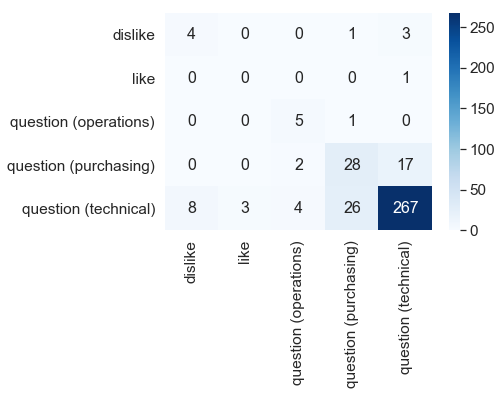

In [152]:
cm=metrics.confusion_matrix(count_nb_pred, y_test)
print(cm)
cm = pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique()))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues",  annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [153]:
keywords = ['keyboard', 'trackpad', 'audio', 'speaker', 'camera', 'webcam', 'crash', 'track pad', 'freeze', 'display', 'lcd', 
            'graphic', 'vmware', 'disappointing', 'oled', 'unresponsive', 'hinge', 'touchpad', 'thunderbolt', 'port', 'bad', 'configuration', 'backlit', 'ram', 'fps',  'video', 'cover',
            'discontinued', 'recalled', 'selling', 'usb', 'driver', 'drives', 'linux', 'boot', 'hot', 'battery', 'stuttering', 'purchasing',
            'stuck', 'frustrating', 'logo', 'mother board', 'motherboard', 'fail', 'sunk', 'sink', 'corner', 'bios', 'firmware', 'kb',
            'review' , 'ssd', 'install', 'resolution', 'wifi', 'slow', 'terrible', 'ubuntu', 'monitor', 'adapter', 
            'shipped', 'shipment', 'ship', 'error', 'sunk', 'sink', 'corner', 'bios', 'firmware', 'refurbished', 'repair', 'repaired', 
            'charger', 'fan', 'charging', 'charge', 'air', 'cooling', 'disappointed', 'rattle', 'rattling', 'noise', 'buy', 
            'heat', 'power', 'released','release', 'volume', 'drain', 'missing', 'recall', 'remove', 'doubt', 'gpu', 'dock', 'wobble', 'break', 'touch pen', 
            'trouble', 'switch', 'overheat', 'cost', 'play', 'pleasant', 'support', 'search', 'disk', 'consider', 'cursor', 'fingerprint', 'overheating', 'throttling', 'throttle', 'thermal', 'warranty', 'flicker', 'against', 'tearing', 'haptic', 'suck', 'hibernate', 'undervolting', 'delay', 'awful', 'hardcase', 'touch', 'disaster', 'driver', 'popping', 'button', 'chassis', 'cracking', 
            'lid', 'atrocious', 'gorgeous', 'impressed', 'service','decal', 'recommendation', 'lace', 'fps', 'case', 'pixel', 'purchase', 'option', 'happy', 'satisfied', 'dislike', 'safeguard', 'garbage', 'window', 'shutting', 'underwhelmed', 'got', 'skin', 'looking', 'decide', 'recommend', 'difference', 'choosing', 'shutdown', 'saturation', 'stain', 'run', 'order', 'molding', 'temp', 'color', 'oversaturated', 'love', 'store', 'complain','return', 'stuttering', 'microphone', 'desperation', 'headphone', 'buzzing', 'ridiculous', 'worse', 'screen', 'poor', 'low',
            'replacement', 'backlight', 'slot', 'compatibility', 'key', 'feedback', 'lagging', 'compare', 'egpu', 'horrible', 'cpu', 'bluetooth', 'dgpu', 'lag', 'retrospective','photo', 'stereo', 'dongle', 'sound']

In [154]:
df['keyword'] = df['combined'].str.findall('|'.join(keywords)).apply(set).str.join(', ')
df.insert(4, 'keyword', df.pop('keyword'))
df.head()

,counter,post date,model,source,keyword,label,number of likes,number of comments,title,content,link,combined
0,1,2022-08-04,inspiron 14 5420,inspiron (dell) - reddit,"run, support, monitor, dock, display, looking,...",question (technical),1,0,inspiron 14 vs xps 13 for use with external,my partner has a desktop with three monitors. ...,https://www.reddit.com/r/Dell/comments/wfxclf/...,inspiron 14 vs xps 13 for use with external my...
1,2,2022-07-31,inspiron 16 plus 7620,inspiron (dell) - reddit,"suck, power, port, bad, drain, battery, air",question (technical),3,6,inspiron 16 plus 7620 battery draining like a,"hey all, had my new inspiron 16 plus 7620 a we...",https://www.reddit.com/r/Dell/comments/wcf3xp/...,inspiron 16 plus 7620 battery draining like a ...
2,3,2022-07-30,inspiron 16 plus 7620,inspiron (dell) - reddit,"speaker, love, monitor, disappointing, poor, b...",question (technical),3,2,dell inspiron 16 plus 7620 bad audio problem with,"hello, i recently bought a brand new dell insp...",https://www.reddit.com/r/Dell/comments/wbsdnz/...,dell inspiron 16 plus 7620 bad audio problem w...
3,4,2022-07-26,inspiron 16 plus 7620,inspiron (dell) - reddit,"temp, boot, satisfied, ram, purchasing",question (technical),1,6,bought an inspiron 7620; need ram,i just bought an inspiron 7620 an am so far ex...,https://www.reddit.com/r/Dell/comments/w88xlc/...,bought an inspiron 7620; need ram i just bough...
4,5,2022-07-23,inspiron 16 plus 7620,inspiron (dell) - reddit,"bios, overheat, keyboard, hot",question (technical),0,4,inspiron 16 plus 7620 - overheating in sleep,"hi, just received my new laptop. nice design a...",https://www.reddit.com/r/Dell/comments/w5qk65/...,inspiron 16 plus 7620 - overheating in sleep h...


In [155]:
# Create a LinearSVM model
tfidf_svc = LinearSVC(C=1)
tfidf_svc.fit(tfidf_train, y_train)

# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate your accuracy using the metrics module
tfidf_svc_score = metrics.accuracy_score(tfidf_svc_pred, y_test)


print("LinearSVC tfidf Score:   %0.3f" % tfidf_svc_score)

LinearSVC tfidf Score:   0.851


In [156]:
# Create a LinearSVM model
count_svc = LinearSVC(C=0.1)
count_svc.fit(count_train, y_train)

# Run predict on your tfidf test data to get your predictions
count_svc_pred = count_svc.predict(count_test)

# Calculate your accuracy using the metrics module
count_svc_score = metrics.accuracy_score(count_svc_pred, y_test)


print("LinearSVC count Score:   %0.3f" % count_svc_score)

LinearSVC count Score:   0.838


# XPS Prediction 

In [157]:
df = pd.concat(map(pd.read_csv, ['reddit (xps filtered).csv', 'reddit (label xps) all.csv']), sort=False)
df = df.drop('counter', axis = 1)
df['post date']=pd.to_datetime(df['post date'])
df = df.drop_duplicates(subset=['link'])
df = df.sort_values(by=['post date','source'], ascending = False)
df.insert(0,'counter',range(1, len(df) + 1))
df.to_csv('reddit (label xps) 1.csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,NaN
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,NaN
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,NaN
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,NaN
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,NaN


In [158]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (label xps) 1.csv')

df = df[df.isna().any(axis=1)]
# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label,combined
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,NaN,xps13 9315 without windows hey i want to buy a...
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,NaN,galaxy book 3 ultra or xps 15 oled currently i...
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,NaN,how do i disable the proximity sensor on xps 9...
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,NaN,ir sensor i've recently got my hands on a xps ...
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,NaN,dell xps 15 9520 performance issue after ram u...


In [159]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (purchasing)',
       'question (technical)', ..., 'question (technical)',
       'question (technical)', 'question (technical)'], dtype=object)

In [160]:
df['label'] = tfidf_svc_pred2
df = df.drop('combined', axis =1)
df.to_csv('reddit (label xps) updated.csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,question (technical)
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,question (purchasing)
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,question (technical)
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,question (technical)
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,question (technical)


In [161]:
# Load data
df = pd.concat(map(pd.read_csv, ['reddit (label xps) updated.csv', 'reddit (label xps) all.csv']))
df = df.drop('counter', axis = 1)
df['post date']=pd.to_datetime(df['post date'])
df = df.drop_duplicates(subset=['link'])
df = df.sort_values(by=['post date','source'], ascending = False)
df.insert(0,'counter',range(1, len(df) + 1))
df.to_csv('reddit (label xps) all.csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,number of likes,number of comments,title,content,link,label
0,1,2023-02-15,xps 13 9315,xps - reddit,0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...,question (technical)
1,2,2023-02-09,xps 15 9510,xps - reddit,1,0,galaxy book 3 ultra or xps 15 oled,currently i have a xps 15 9510 1080p model. fo...,https://www.reddit.com/r/XPS/comments/10xotyn/...,question (purchasing)
2,3,2023-02-08,xps 15 9520,xps - reddit,1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...,question (technical)
3,4,2023-02-07,xps 13 9310,xps - reddit,1,2,ir sensor,i've recently got my hands on a xps 13 9310 an...,https://www.reddit.com/r/XPS/comments/10w80wz/...,question (technical)
4,5,2023-02-02,xps 15 9520,xps - reddit,3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...,question (technical)


# Inspiron new data

In [162]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (inspiron filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [163]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)'], dtype=object)

In [164]:
df.insert(4,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label inspiron).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,label,number of likes,number of comments,title,content,link
0,1,2022-08-04,inspiron 14 5420,inspiron (dell) - reddit,question (technical),1,0,inspiron 14 vs xps 13 for use with external,my partner has a desktop with three monitors. ...,https://www.reddit.com/r/Dell/comments/wfxclf/...
1,2,2022-07-31,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),3,6,inspiron 16 plus 7620 battery draining like a,"hey all, had my new inspiron 16 plus 7620 a we...",https://www.reddit.com/r/Dell/comments/wcf3xp/...
2,3,2022-07-30,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),3,2,dell inspiron 16 plus 7620 bad audio problem with,"hello, i recently bought a brand new dell insp...",https://www.reddit.com/r/Dell/comments/wbsdnz/...
3,4,2022-07-26,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),1,6,bought an inspiron 7620; need ram,i just bought an inspiron 7620 an am so far ex...,https://www.reddit.com/r/Dell/comments/w88xlc/...
4,5,2022-07-23,inspiron 16 plus 7620,inspiron (dell) - reddit,question (technical),0,4,inspiron 16 plus 7620 - overheating in sleep,"hi, just received my new laptop. nice design a...",https://www.reddit.com/r/Dell/comments/w5qk65/...


# G15 new data

In [165]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (dellg15 filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [166]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (purchasing)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)'], dtype=object)

In [167]:
df.insert(4,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label dellg15).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,label,number of likes,number of comments,title,content,link
0,1,2022-08-07,dell g15 5520,dellg15 (gaming) - reddit,question (technical),2,7,discussiondell g15 5520 vbios update tgp chang...,what’s weird?,https://www.reddit.com/r/GamingLaptops/comment...
1,2,2022-08-03,dell g15 5520,dellg15 (gaming) - reddit,question (technical),2,5,discussiondell g15 5520 what do you think of,i want to buy dell g15 5520 12700h 16gb ddr5 r...,https://www.reddit.com/r/GamingLaptops/comment...
2,3,2022-08-03,dell g15 5520,dellg15 (gaming) - reddit,question (technical),1,6,tech supportbought new dell g15 5520 3050ti la...,inb4 my issue is that i bought a dell,https://www.reddit.com/r/GamingLaptops/comment...
3,4,2022-08-02,dell g15 5520,dellg15 (gaming) - reddit,question (technical),6,7,tech supportneed help with dell g15 5520,"hi, i just got my dell g15 5520 today and was ...",https://www.reddit.com/r/GamingLaptops/comment...
4,5,2022-08-02,dell g15 5525,dellg15 (gaming) - reddit,question (technical),4,2,discussionis displayport on dell g15 5525 (680...,i'm looking for a new laptop with 6800h and i ...,https://www.reddit.com/r/GamingLaptops/comment...


# Vostro new data

In [168]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (vostro filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [169]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (technical)'], dtype=object)

In [170]:
df.insert(4,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label vostro).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,source,label,number of likes,number of comments,title,content,link
0,1,2022-07-13,vostro 7620,vostro (dell) - reddit,question (technical),0,2,i'm fed up with this dell trash: vostro 7620 i...,i do not understand how they haven't figured o...,https://www.reddit.com/r/Dell/comments/vybhbf/...
1,2,2022-07-10,vostro 7620,vostro (dell) - reddit,question (technical),3,6,vostro 7620,"i haven't seen one yet, so here is mine: it fr...",https://www.reddit.com/r/Dell/comments/vvw919/...
2,3,2022-07-07,vostro 5620,vostro (dell) - reddit,question (technical),1,0,"dell vostro 5620, windows 11 stuck at 48fps, b...",model: dell vostro 5620 cpu: i7-1260p gpu: iri...,https://www.reddit.com/r/Dell/comments/vtkb2j/...
3,4,2022-06-10,vostro 7620,vostro (dell) - reddit,question (purchasing),6,13,new dell inspiron 16 plus and vostro 7620 lapt...,i can't wait for this three laptops come to us...,https://www.reddit.com/r/Dell/comments/v9b05b/...
4,5,2022-05-28,vostro 5620,vostro (dell) - reddit,question (technical),1,6,vostro 5620 throttling at low,"hey, just got a 5620 with an i7-1260p, i don't...",https://www.reddit.com/r/Dell/comments/uzqdtv/...


# XPS odm new data

In [171]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (xps odm filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [172]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'dislike', 'question (technical)',
       'question (technical)', 'dislike', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'like', 'question (purchasing)',
       'question (technical)', 'question (purchasing)',
       'question (technical)', 

In [173]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm xps).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link
0,1,2023-02-15,xps 13 9315,Portofino ADL,xps - reddit,question (technical),0,1,xps13 9315 without windows,"hey i want to buy a 9315 with linux, and maybe...",https://www.reddit.com/r/XPS/comments/1130y8l/...
1,2,2023-02-08,xps 15 9520,Fiorano ADL,xps - reddit,question (technical),1,2,how do i disable the proximity sensor on xps 9...,everytime i walk away from my computer to go d...,https://www.reddit.com/r/XPS/comments/10xb6vy/...
2,3,2023-02-02,xps 15 9520,Fiorano ADL,xps - reddit,question (technical),3,6,dell xps 15 9520 performance issue after ram u...,"hey guys, i upgraded my ram from 32gb to 64gb ...",https://www.reddit.com/r/XPS/comments/10rmcwm/...
3,4,2023-01-27,xps 13 plus 9320,Tributo ADL,xps - reddit,question (technical),2,4,xps 13 plus 9320 i7 1280p tdp,hi everyone. today i’ve discovered something t...,https://www.reddit.com/r/XPS/comments/10mpwqu/...
4,5,2023-01-25,xps 13 plus 9320,Tributo ADL,xps - reddit,question (technical),1,1,received from dell outlet an xps 13 plus 9320 ...,is it normal for the non-touch screen model to...,https://www.reddit.com/r/XPS/comments/10ky1pi/...


# Inspiron odm new data

In [174]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (inspiron odm filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [175]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (purchasing)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)'], dtype=object)

In [176]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm inspiron).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link
0,1,2022-08-04,inspiron 14 5420,Odin N5 14 ADL,inspiron (dell) - reddit,question (technical),1,0,inspiron 14 vs xps 13 for use with external,my partner has a desktop with three monitors. ...,https://www.reddit.com/r/Dell/comments/wfxclf/...
1,2,2022-07-31,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),3,6,inspiron 16 plus 7620 battery draining like a,"hey all, had my new inspiron 16 plus 7620 a we...",https://www.reddit.com/r/Dell/comments/wcf3xp/...
2,3,2022-07-30,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),3,2,dell inspiron 16 plus 7620 bad audio problem with,"hello, i recently bought a brand new dell insp...",https://www.reddit.com/r/Dell/comments/wbsdnz/...
3,4,2022-07-26,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),1,6,bought an inspiron 7620; need ram,i just bought an inspiron 7620 an am so far ex...,https://www.reddit.com/r/Dell/comments/w88xlc/...
4,5,2022-07-23,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),0,4,inspiron 16 plus 7620 - overheating in sleep,"hi, just received my new laptop. nice design a...",https://www.reddit.com/r/Dell/comments/w5qk65/...


# Vostro odm new data

In [177]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (vostro odm filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [178]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)'], dtype=object)

In [179]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm vostro).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link
0,1,2022-07-07,vostro 5620,Odin V5 16 ADL,vostro (dell) - reddit,question (technical),1,0,"dell vostro 5620, windows 11 stuck at 48fps, b...",model: dell vostro 5620 cpu: i7-1260p gpu: iri...,https://www.reddit.com/r/Dell/comments/vtkb2j/...
1,2,2022-05-28,vostro 5620,Odin V5 16 ADL,vostro (dell) - reddit,question (technical),1,6,vostro 5620 throttling at low,"hey, just got a 5620 with an i7-1260p, i don't...",https://www.reddit.com/r/Dell/comments/uzqdtv/...
2,3,2022-05-24,vostro 5320,Odin 13 V ADL,vostro (dell) - reddit,question (technical),5,13,"is the new inspiron 14"" with an i7-1255u good ...",howdy all! i am looking forward to buying a ne...,https://www.reddit.com/r/Dell/comments/uwmymc/...


# XPS odm comment data

In [180]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (xps odm comment filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [181]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
   

In [182]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm comment xps).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link,content of comment
0,1,2022-08-08,xps 13 plus 9320,Tributo ADL,dellxps - reddit,question (technical),0,1,xps 13 plus charging,hello everyone finally got my laptop. its so g...,https://www.reddit.com/r/DellXPS/comments/wiuw...,(0 children)Just time it yourself and see who ...
1,2,2022-08-07,xps 13 plus 9320,Tributo ADL,dellxps - reddit,question (technical),4,24,"is dells qc actually that bad, or is it just t...",i just ordered my xps 13 plus 9320 for univers...,https://www.reddit.com/r/DellXPS/comments/wii7...,(6 children)The overwhelming majority of custo...
2,3,2022-08-07,xps 13 plus 9320,Tributo ADL,dellxps - reddit,question (purchasing),1,4,what’s the best dock for my new xps 13 plus?,"i ordered my xps 13 plus the other day, and ju...",https://www.reddit.com/r/DellXPS/comments/winy...,(2 children)a) Those are DisplayLink docks. Ge...
3,4,2022-08-07,xps 13 plus 9320,Tributo ADL,dellxps - reddit,question (technical),1,0,dell xps 13 plus keyboard backlight strobing a...,so my dell xps 13 plus running ubuntu 22.04 ra...,https://www.reddit.com/r/DellXPS/comments/wi2y...,No comments
4,5,2022-08-06,xps 13 plus 9320,Tributo ADL,dellxps - reddit,question (purchasing),2,1,is the xps 13 7390 a good option?im going into...,i had one until upgrading to an xps 13 plus. i...,https://www.reddit.com/r/DellXPS/comments/wi1o...,(0 children)I had one until upgrading to an xp...


# Inspiron odm comment data

In [183]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (inspiron odm comment filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [184]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (purchasing)',
       'question (purchasing)', 'question (technical)',
       'question (purchasing)', 'question (technical)',
       'question (technical)', 'question (technical)',
       'question (purchasing)', 'question (purchasing)',
       'question (technical)', 'question (technical)',
       'question (technical)', 'question (technical)'], dtype=object)

In [185]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm comment inspiron).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link,content of comment
0,1,2022-08-04,inspiron 14 5420,Odin N5 14 ADL,inspiron (dell) - reddit,question (technical),1.0,0.0,inspiron 14 vs xps 13 for use with external,my partner has a desktop with three monitors. ...,https://www.reddit.com/r/Dell/comments/wfxclf/...,No comments
1,2,2022-07-31,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),3.0,6.0,inspiron 16 plus 7620 battery draining like a,"hey all, had my new inspiron 16 plus 7620 a we...",https://www.reddit.com/r/Dell/comments/wcf3xp/...,(1 child)I'm also finding battery life unpredi...
2,3,2022-07-30,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),3.0,2.0,dell inspiron 16 plus 7620 bad audio problem with,"hello, i recently bought a brand new dell insp...",https://www.reddit.com/r/Dell/comments/wbsdnz/...,"(1 child)Just for you, I dug out a pair of Sku..."
3,4,2022-07-26,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),1.0,6.0,bought an inspiron 7620; need ram,i just bought an inspiron 7620 an am so far ex...,https://www.reddit.com/r/Dell/comments/w88xlc/...,"(4 children)If it maxes at 32, probs can’t go ..."
4,5,2022-07-23,inspiron 16 plus 7620,Odin N 16 ADL-H,inspiron (dell) - reddit,question (technical),0.0,4.0,inspiron 16 plus 7620 - overheating in sleep,"hi, just received my new laptop. nice design a...",https://www.reddit.com/r/Dell/comments/w5qk65/...,(0 children)I have the new 7620 2 in 1. Same i...


# Vostro odm comment data

In [186]:
import pandas as pd

# Load data
df = pd.read_csv('reddit (vostro odm comment filtered).csv')

df = df.dropna(axis=0)

# combined only list
df['combined'] = df['title'] + ' ' + df['content']

Xnew = list(df['combined'])

In [187]:
tfidf_test2 = tfidf_vectorizer.transform(Xnew)
tfidf_test2

# Run predict on your count test data to get your predictions
tfidf_svc_pred2 = tfidf_svc.predict(tfidf_test2)
tfidf_svc_pred2

array(['question (technical)', 'question (technical)',
       'question (technical)'], dtype=object)

In [188]:
df.insert(5,'label',tfidf_svc_pred2)
df = df.drop('combined', axis =1)
df.to_csv('reddit (label odm comment vostro).csv', encoding='utf_8_sig', index=False)
df.head()

,counter,post date,model,family grandparent,source,label,number of likes,number of comments,title,content,link,content of comment
0,1,2022-07-07,vostro 5620,Odin V5 16 ADL,vostro (dell) - reddit,question (technical),1,0,"dell vostro 5620, windows 11 stuck at 48fps, b...",model: dell vostro 5620 cpu: i7-1260p gpu: iri...,https://www.reddit.com/r/Dell/comments/vtkb2j/...,No comments
1,2,2022-05-28,vostro 5620,Odin V5 16 ADL,vostro (dell) - reddit,question (technical),1,6,vostro 5620 throttling at low,"hey, just got a 5620 with an i7-1260p, i don't...",https://www.reddit.com/r/Dell/comments/uzqdtv/...,(4 children)Looking at the photos for the 5620...
2,3,2022-05-24,vostro 5320,Odin 13 V ADL,vostro (dell) - reddit,question (technical),5,13,"is the new inspiron 14"" with an i7-1255u good ...",howdy all! i am looking forward to buying a ne...,https://www.reddit.com/r/Dell/comments/uwmymc/...,(1 child)I have the inspiron 14 with the ryzen...
